# Importing Python Packages and Data

In [322]:
# Import everything needed

import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import matplotlib
import matplotlib.collections

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import precision_recall_curve

matplotlib.rcParams['font.family'] = ['arial']

In [323]:
total_data = pd.read_csv("cleaned_data.dbcan_cog_HGT.tsv", sep="\t")
total_data = total_data.drop(columns = ['Unnamed: 0'])

In [324]:
print(total_data.shape)
total_data.head()

(3772, 4564)


,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


In [325]:
# Removing soil! Separating PA and NPA!

df = total_data[total_data["Classification"] != "soil"]
print(df.shape)
order = df['Order']
df.head()

(3261, 4564)


,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.16
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45


# Data Preprocessing and Feature Selection, all models

In [326]:
# Scaling data with Standard Scaler, code from Muyoung

features = df.columns[4:]
scaler = StandardScaler().fit(df[features])
df_normalized = pd.DataFrame(scaler.transform(df[features]), columns=features)
df = pd.concat([df.iloc[:, :4], df_normalized], axis=1)
df.head()

,taxonID,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664,Horizontally_Transferred_%
0,2511231155,Acinetobacter,NPA,NPA,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
1,2519103115,Acinetobacter,NPA,NPA,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.313281
2,2519899735,Acinetobacter,NPA,NPA,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.331415
3,2526164562,Acinetobacter,NPA,NPA,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.218343
4,2529293005,Acinetobacter,NPA,NPA,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,...,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738,-0.294080


In [327]:
# Removing features with zero variance, code from Muyoung 

constant_filter = VarianceThreshold(threshold=0) 
constant_filter.fit(df[features])
features = constant_filter.get_feature_names_out(features)

X = df[features]
y = df["Classification"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Principal Component Analysis

In [328]:
# Actually doing the PCA

pca = decomposition.PCA(n_components=2)

pca_result = pca.fit_transform(X)

# Making labels for plotting the graph

labels = y.ravel()

for idx, val in enumerate(labels):
    if val == "NPA":
        labels[idx] = 0
    elif val == "PA":
        labels[idx] = 1
    else:
        print("Error!")

x_plot = pca_result[:,0]
y_plot = pca_result[:,1]

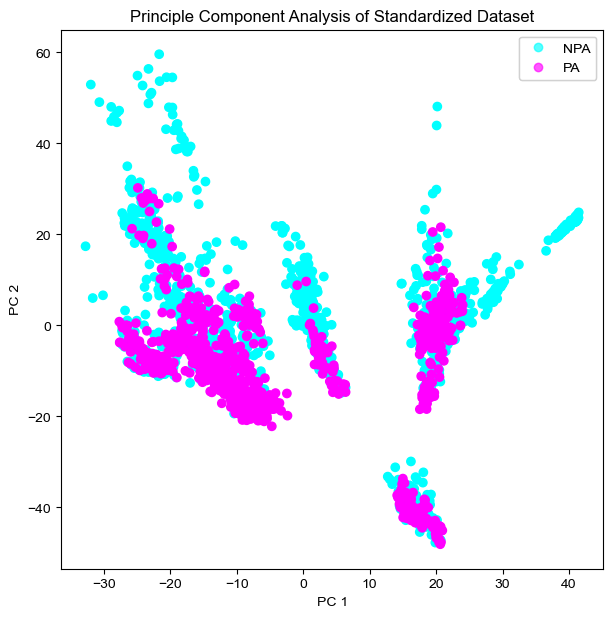

In [329]:
# Plotting by classification

fig, ax = plt.subplots(1, figsize = (7,7))

scatter1 = ax.scatter(x_plot,y_plot, c = labels, cmap = "cool")
handles, _ = scatter1.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = ax.legend(handles, ["NPA", "PA"], loc="upper right")
ax.add_artist(legend1)

pca_result = pd.DataFrame(pca_result)
    
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Principle Component Analysis of Standardized Dataset")
plt.savefig("PCA_SDS_Final_Project.svg")
plt.show()

In [330]:
# This block of code deals with making bacterial orders categorical, for PC visualization

orders = order.unique()
order_numeric = np.zeros((len(orders),1))

order_forplotting = order

for idx, val in enumerate(orders):
    order_forplotting = order_forplotting.replace(str(val), idx)

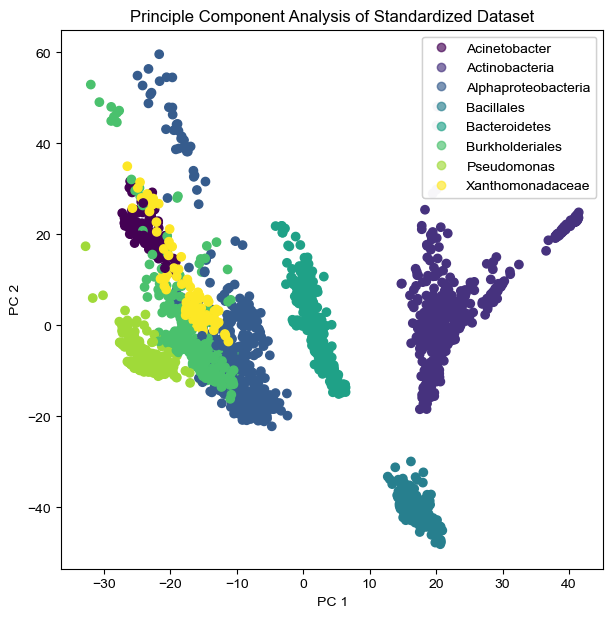

In [331]:
# Plotting by order

fig, ax = plt.subplots(1, figsize = (7,7))

scatter1 = ax.scatter(x_plot,y_plot, c = order_forplotting.ravel())
handles, _ = scatter1.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = ax.legend(handles, orders, loc="upper right")
ax.add_artist(legend1)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Principle Component Analysis of Standardized Dataset")
plt.savefig("PCA_SDS_Final_Project_Orders.svg")
plt.show()

In [332]:
labels.shape

(3261,)

In [333]:
dataset_pca = pd.DataFrame(abs(pca.components_),columns=X.columns, index=['PC_1', 'PC_2'])
dataset_pca.to_csv('PCA_of_Dataset.csv')

In [334]:
dataset_pca_t = dataset_pca.transpose()

In [335]:
dataset_pca_t.nlargest(20, "PC_1")["PC_1"]

COG0391    0.040889
COG2138    0.040196
COG0311    0.040104
COG3480    0.040014
COG1481    0.039897
COG1799    0.039878
CE14       0.039823
COG3253    0.039497
COG1837    0.039455
COG3599    0.039155
COG0214    0.038961
COG0811    0.038852
COG1623    0.038783
COG1847    0.038581
COG1461    0.037936
COG1566    0.037797
COG1438    0.037690
COG5282    0.037641
COG0841    0.037634
COG0795    0.037535
Name: PC_1, dtype: float64

In [336]:
dataset_pca_t.nlargest(20, "PC_2")["PC_2"]

COG0321    0.042216
COG0792    0.040508
COG0539    0.039709
COG1109    0.039575
COG0726    0.038774
COG0484    0.038504
COG1678    0.038162
COG0322    0.038046
COG0221    0.037873
COG0354    0.037844
COG0238    0.037730
COG0108    0.037338
COG1391    0.036615
COG1873    0.036538
COG1284    0.036452
COG1164    0.036084
COG0609    0.035778
COG0240    0.035664
COG1658    0.035550
COG1939    0.035541
Name: PC_2, dtype: float64

# Feature Selection

In [337]:
# https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
coef = model.coef_[0]

In [338]:
# Trimming features from the X dataset

imp_features = pd.Series(X.columns)[list(coef!=0)]
X_train = X_train[imp_features]
X_test = X_test[imp_features]
X = X[imp_features]

In [339]:
# Saving important features to file

imp_features.to_csv('logistic_regression_features.csv', index=True, header=False)

In [340]:
# Making file with all coefficents of important features (for feature importance)

all_features_coeff = pd.concat([pd.DataFrame(features), pd.DataFrame(coef)], axis = 1)
all_features_coeff.columns = 'Features', 'Coefficents'

In [341]:
all_features_coeff

,Features,Coefficents
0,AA1,0.0
1,AA10,0.0
2,AA12,0.0
3,AA3,0.0
4,AA4,0.0
...,...,...
4535,COG5661,0.0
4536,COG5662,0.0
4537,COG5663,0.0
4538,COG5664,0.0


# Data Visualization

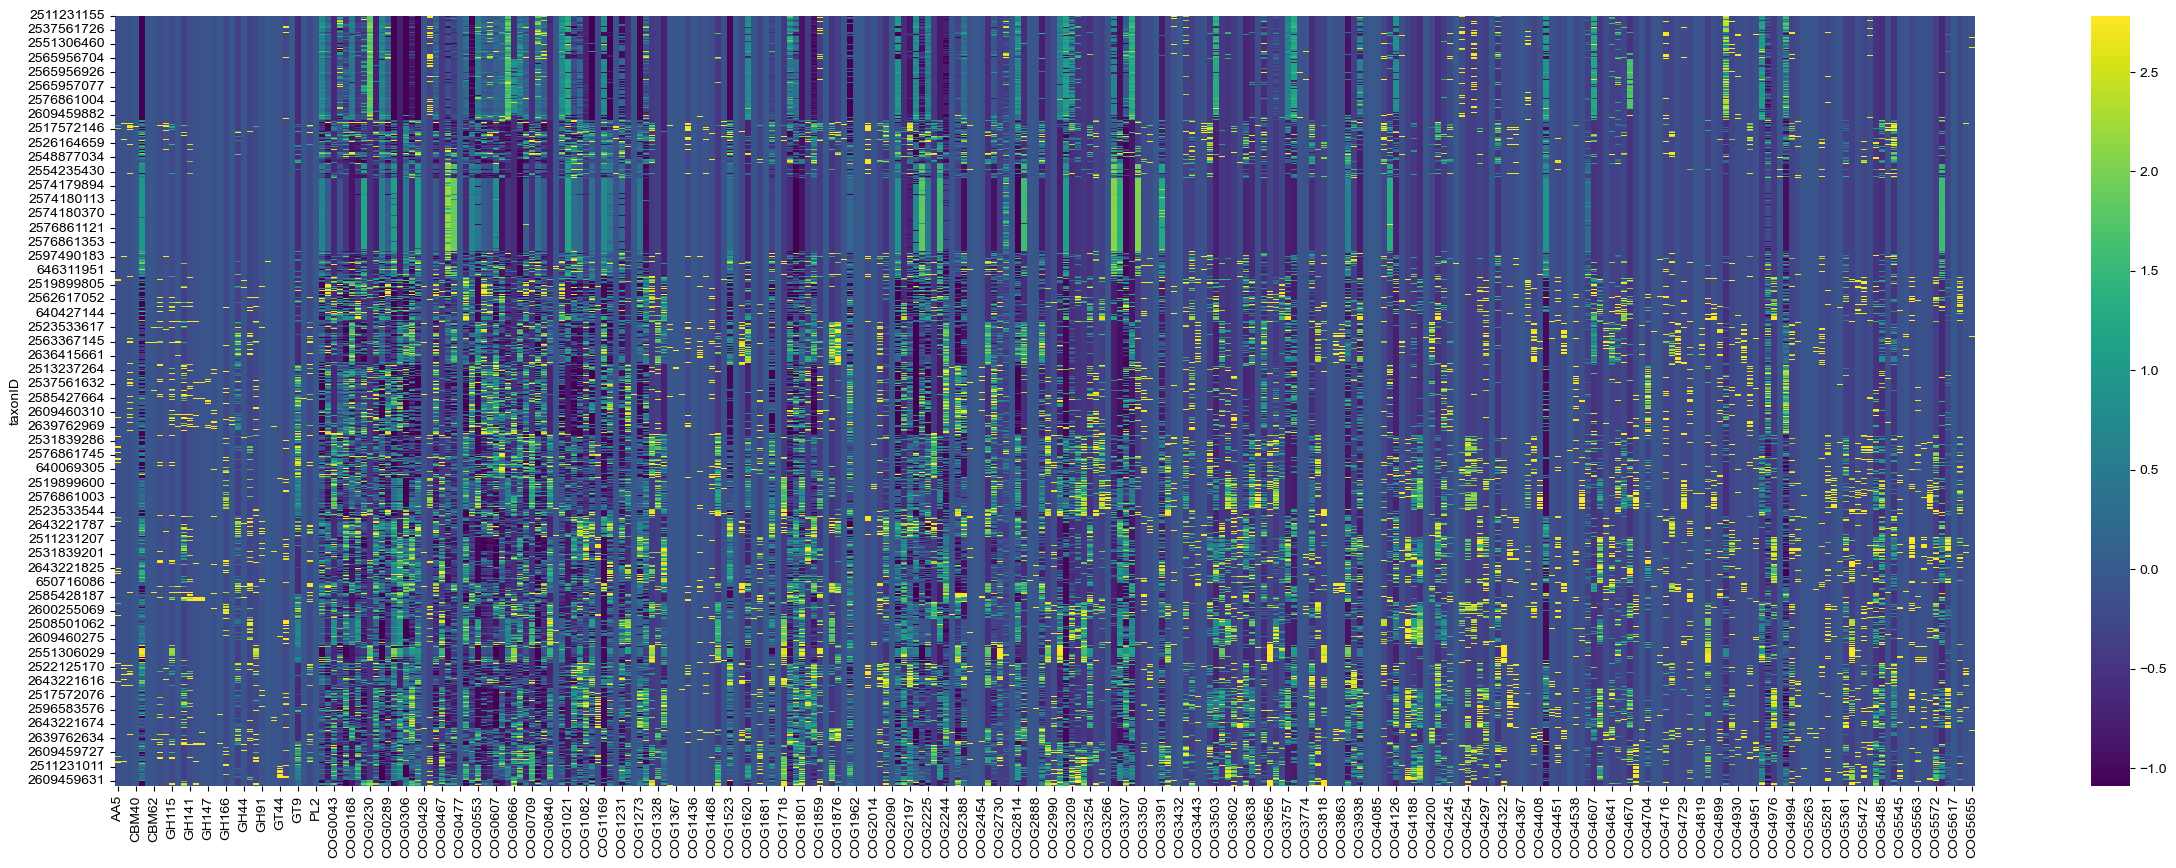

(3261, 310)


In [342]:
fig, ax = plt.subplots(figsize=(30,10))
X_forplotting = X
X_forplotting.index = df['taxonID']
ax = sb.heatmap(X_forplotting, robust = True, cmap = 'viridis') # square = True, 
plt.show()
print(X_forplotting.shape)

# Model Training

## Logistic Regression, Three Penalties

In [343]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [344]:
y_train

3195     PA
2136     PA
654     NPA
141     NPA
1957    NPA
       ... 
311     NPA
2815     PA
2682     PA
2441     PA
3188     PA
Name: Classification, Length: 2184, dtype: object

In [345]:
clf_l1 = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'l1', solver = 'saga').fit(X_train, y_train)
clf_l2 = LogisticRegression(random_state=42, max_iter = 500, penalty = 'l2').fit(X_train, y_train)
clf_en = LogisticRegression(random_state=42, max_iter = 5000, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5).fit(X_train, y_train)

In [346]:
y_pred_l1 = clf_l1.predict_proba(X_test)
y_pred_l2 = clf_l2.predict_proba(X_test)
y_pred_en = clf_en.predict_proba(X_test)

In [347]:
clf_l1.score(X_train, y_train)

0.9954212454212454

In [348]:
clf_l2.score(X_train, y_train)

0.9986263736263736

In [349]:
clf_en.score(X_train, y_train)

0.9977106227106227

In [350]:
clf_l1.score(X_test, y_test)

0.8746518105849582

In [351]:
clf_l2.score(X_test, y_test)

0.8792943361188487

In [352]:
clf_en.score(X_test, y_test)

0.8783658310120706

In [353]:
precision_l1, recall_l1, thresholds_l1 = precision_recall_curve(y_test, y_pred_l1[:,0], pos_label = ["NPA"])
precision_l2, recall_l2, thresholds_l2 = precision_recall_curve(y_test, y_pred_l2[:,0], pos_label = ["NPA"])
precision_en, recall_en, thresholds_en = precision_recall_curve(y_test, y_pred_en[:,0], pos_label = ["NPA"])

[]

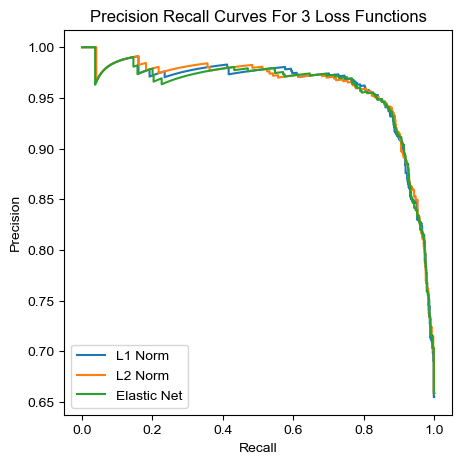

In [354]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_l1, precision_l1)
ax.plot(recall_l2, precision_l2)
ax.plot(recall_en, precision_en)
ax.legend(['L1 Norm', 'L2 Norm', 'Elastic Net'])
ax.set_title('Precision Recall Curves For 3 Loss Functions')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

In [399]:
# Get largest features (using absolute value!!)

coef_l1 = abs(clf_l1.coef_[0])
coef_l2 = abs(clf_l2.coef_[0])
coef_en = abs(clf_en.coef_[0])

imp_features.reset_index(drop=True, inplace=True)

l1_coeff = pd.concat([pd.DataFrame(imp_features), pd.DataFrame(coef_l1)], axis = 1)
l1_coeff.index = imp_features
l1_coeff.columns = 'Features', 'Coefficents'

l2_coeff = pd.concat([pd.DataFrame(imp_features), pd.DataFrame(coef_l2)], axis = 1)
l2_coeff.index = imp_features
l2_coeff.columns = 'Features', 'Coefficents'

en_coeff = pd.concat([pd.DataFrame(imp_features), pd.DataFrame(coef_en)], axis = 1)
en_coeff.index = imp_features
en_coeff.columns = 'Features', 'Coefficents'

In [400]:
l1_coeff.nlargest(20, 'Coefficents')['Coefficents']

COG0168    1.103393
COG2608    1.071244
COG2217    1.070169
GH74       0.967517
COG1830    0.881179
COG4976    0.843398
COG0289    0.803390
COG2930    0.787599
COG2225    0.785761
COG5554    0.780644
COG0029    0.772317
COG0697    0.767490
COG4191    0.736818
COG4373    0.716411
COG1324    0.699838
COG3189    0.699478
COG3638    0.660655
COG4722    0.623472
COG0111    0.618021
COG3329    0.609894
Name: Coefficents, dtype: float64

In [401]:
l2_coeff.nlargest(20, 'Coefficents')['Coefficents']

COG2217    1.337284
COG0168    1.330807
COG1830    1.201942
GH74       1.077790
COG2608    1.062020
COG2930    1.011558
COG2225    0.976513
COG0697    0.957241
COG0029    0.900276
COG3638    0.827638
COG4373    0.827581
COG0289    0.824341
COG3189    0.808186
COG4191    0.800956
COG1324    0.795323
COG1240    0.764415
COG5554    0.763305
COG4722    0.758586
COG4976    0.757622
COG0111    0.739497
Name: Coefficents, dtype: float64

In [402]:
en_coeff.nlargest(20, 'Coefficents')['Coefficents']

COG0168    1.172095
COG2217    1.132637
COG2608    1.109876
GH74       1.039902
COG1830    1.005036
COG2930    0.909090
COG2225    0.878465
COG0697    0.821019
COG0289    0.815948
COG4976    0.813432
COG0029    0.791734
COG4191    0.779559
COG5554    0.773730
COG4373    0.761345
COG1324    0.745492
COG3638    0.722740
COG3189    0.710751
COG4722    0.693134
COG4297    0.672641
COG0111    0.672074
Name: Coefficents, dtype: float64

## Support Vector Machine Classifier

In [413]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svc = SVC(gamma = 'auto', probability = True).fit(X_train, y_train)
clf_svc2 = SVC(kernel = 'linear', probability = True).fit(X_train, y_train)
clf_svc3 = SVC(kernel = 'sigmoid', probability = True).fit(X_train, y_train)

In [404]:
clf_svc.score(X_train, y_train)

0.9839743589743589

In [405]:
clf_svc.score(X_test, y_test)

0.8960074280408542

In [411]:
clf_svc2.score(X_train, y_train)

0.9995421245421245

In [412]:
clf_svc2.score(X_test, y_test)

0.8644382544103992

In [414]:
clf_svc3.score(X_train, y_train)

0.9528388278388278

In [415]:
clf_svc3.score(X_test, y_test)

0.8811513463324049

In [406]:
y_pred_1 = clf_svc.predict_proba(X_test)

In [407]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

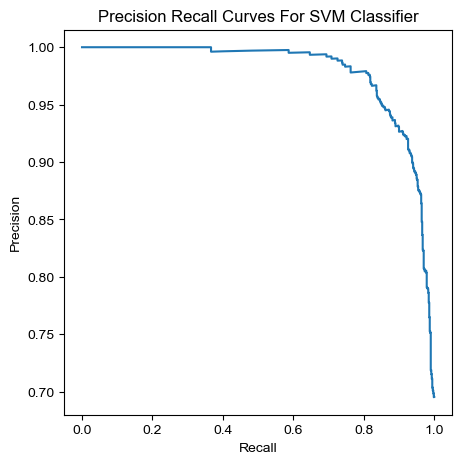

In [408]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For SVM Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

## Gaussian Naive Bayes Classifier

In [190]:
# https://scikit-learn.org/stable/modules/naive_bayes.html BAD AT PREDICTIONS

gnb = GaussianNB().fit(X_train,y_train)

In [191]:
y_pred = gnb.predict_proba(X_test)

In [192]:
gnb.score(X_train,y_train)

0.6831501831501832

In [193]:
gnb.score(X_test,y_test)

0.6527390900649953

In [194]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test, y_pred_1[:,0], pos_label = 'NPA')

[]

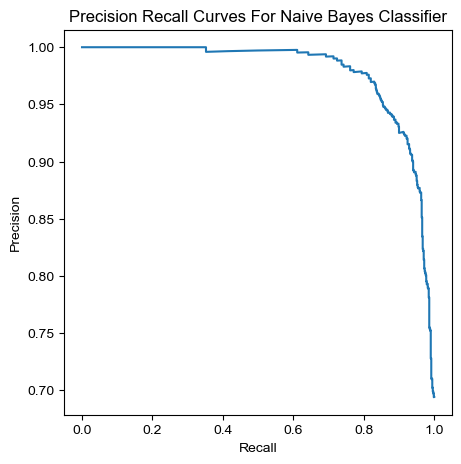

In [195]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.plot(recall_1, precision_1)
ax.set_title('Precision Recall Curves For Naive Bayes Classifier')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

plt.plot()

# Testing on Soil

In [197]:
df_soil = total_data[total_data["Classification"] == "soil"]
X_soil = df_soil[imp_features]

In [215]:
y_pred_l1_soil = clf_l1.predict(X_soil)
y_pred_l2_soil = clf_l2.predict(X_soil)
y_pred_en_soil = clf_en.predict(X_soil)
y_pred_svc_soil = clf_svc.predict(X_soil)
y_pred_gnb_soil = gnb.predict(X_soil)

In [209]:
X_soil.shape

(511, 310)

In [208]:
sum(y_pred_l1_soil == y_pred_l2_soil)

511

In [210]:
sum(y_pred_l1_soil == y_pred_en_soil)

511

In [211]:
sum(y_pred_l1_soil == y_pred_svc_soil)

511

In [216]:
sum(y_pred_l1_soil == y_pred_gnb_soil)

511

In [217]:
# All predictions are the same! This might be because my features are so small (only around 300)